<a href="https://colab.research.google.com/github/caiociardelli/sphglltools/blob/main/doc/5_Volumetric_expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Volumetric expansion: B-splines + spherical harmonics

Author: Caio Ciardelli
<br>
<br>
If you use this Jupyter, please, cite the following paper:
<br>
<br>
Ciardelli, C., Bozdağ, E., Peter, D., and Van der Lee, S., 2022. SphGLLTools: A toolbox for visualization of large seismic model files based on 3D spectral-element meshes. Computer & Geosciences, v. 159, 105007, doi: https://doi.org/10.1016/j.cageo.2021.105007
<br>
<br>

####Expanding 3D functions

We can express relatively well-behaved functions as an infinite series of trigonometric functions, *Legendre polynomials*, or B-splines. Sines, cosines, and the *Legendre polynomials* form an orthogonal basis and thus have a more convenient way of calculating the coefficients of the series. B-splines, except for the zero degree ones, in general, are not orthogonal.  Therefore, matrix inversion is required to extract the coefficients. On the other hand, they allow for more flexibility and can handle uneven nodes distribution easier. 
<br>
<br>
To represent 3D scalar fields with spherical symmetry, such as Earth's gravity field (in Newtonian physics), or even Earth's models for wave propagation, the combination of b-splines for the radial basis functions with spherical harmonics for the azimuthal and polar basis is very convenient.
<br>
<br>
One modification required to use B-splines as the radial basis is the inclusion of a $r^2$ factor in the matrix calculation:
<br>
<br>
\begin{equation}
  A_{s',\,s}
  \,=\,\int_{t_0}^{t_{Ns}} B_{s',\,n}\,(r)\,B_{s,\,n}\,(r)\,r^2\,dr
\end{equation}
<br>
<br>
Then, a function $f\,(r,\,\theta,\,\phi)$ can be approximated as:
<br>
<br>
\begin{equation}
  f\,(r,\,\theta,\phi)
  \,\approx\,
  \sum_{s\,=\,0}^{Ns}
  \sum_{n\,=\,0}^{\infty}
  \sum_{m\,=\,0}^{n}
  R_s\,(r)\left(a_{m,\,n,\,s}\cos m\phi
  \,+\,
  b_{m,\,n,\,s}\sin m\phi\right)\,P_{n,\,m}\,(\cos\theta)
\end{equation}
<br>
<br>
\begin{equation}
  a_{m,\,n,\,s}
  \,=\,
  \sum_{s\,=\,0}^{Ns}
  {A_{s',\,s}}^{-1}
  \int_{-\pi}^{\pi}
  \int_{0}^{\pi}
  \int_{r_1}^{r_2}
  R_s\,(r)\,f\,(r,\,\theta,\phi)\,P_{n,\,m}\,(\cos\theta)\,\cos m\phi\,\,r^2\sin\theta\,dr\,d\theta\,d\phi\\
  b_{m,\,n,\,s}
  \,=\,
  \sum_{s\,=\,0}^{Ns}
  {A_{s',\,s}}^{-1}
  \int_{-\pi}^{\pi}
  \int_{0}^{\pi}
  \int_{r_1}^{r_2}
  R_s\,(r)\,f\,(r,\,\theta,\phi)\,P_{n,\,m}\,(\cos\theta)\,\sin m\phi\,\,r^2\sin\theta\,dr\,d\theta\,d\phi,
\end{equation}
<br>
<br> 
where $R_s\,(r)\,=\,B_{s,\,3}\,(r)$ is the radial basis composed of cubic *B-splines*.
<br>
<br>

####Algorithm

Now we need to compute volumetric integrals. Even `Numpy` and `Scipy` packages are not fast enough for the kinds of calculations we need to handle now. `Numba` can speed up the code a lot, but only when we wrote the *Python* code in a way that the *JIT* compiler can translate it to machine code, which is not always possible.
<br>
<br>
One reliable way of achieving very high performance is writing the computational intensive routines in *C* or *Fortran*, compiling them as a shared library, and then calling it from *Python*. We can achieve that by combining `Ctypes` and `Numpy`.
<br>
<br>

####C code

#####Constants

In [ ]:
%%file constants.h
/* Do not change anything in this file! */

#ifndef CONSTANTS_H
#define CONSTANTS_H
/* Pi constant */
static const double PI        = 3.14159265358979323846;
/* Numerical threshold to detect singular values */
static const double EPSILON   = 1E-15;

/* K1 and K2 are constants used to prevent underflow
   in the Associated Legendre funtions */
static const double K1        = 1E300;
static const double K2        = 1E-150;
#endif

Writing constants.h


#####Exmath library

In [ ]:
%%file exmath.h

#ifndef EXMATH_H
#define EXMATH_H
inline double square (double v)
{
  return v * v;
}

inline double cube (double v)
{
  return v * v * v;
}

double factorial (unsigned n);
double factorial2 (unsigned n);

unsigned gaussJordan (unsigned n, double M[n][n]);

double simpson (double x1, double x2, unsigned nx, double f[nx]);

void weights3 (unsigned nx, unsigned ny, unsigned nz,
               double W[nx][ny][nz]);

double simpson3 (double x1, double x2,
                 double t1, double t2,
                 double p1, double p2,
                 unsigned nx, unsigned ny, unsigned nz,
                 double W[nx][ny][nz], double F[nx][ny][nz]);

double bSplines (double x, unsigned nn, unsigned ng, double Tn[nn],
                 unsigned i);
#endif

Writing exmath.h


In [ ]:
%%file exmath.c

#include <math.h>
#include "constants.h"

struct Pair
{
  /* Used to store the permutations carried out
     during the matrix inversion */
  unsigned j1;
  unsigned j2;
};


double factorial (unsigned n)
{
  /* Computes the factorial of n */
  double r = 1;

  for (unsigned i = 2; i <= n; i++)

    r *= i;

  return r;
}

double factorial2 (unsigned n)
{
  /* Computes the double factorial of n */
  double r = 1;

  for (unsigned i = n; i >= 0; i -= 2)
  {
    if (i == 0 || i == 1) return r;

    else r *= i;
  }

  return r;
}

static void swapRows (unsigned n,
                      double M[n][n], double T[n][n],
                      unsigned i1, unsigned i2)
{
  /* Swaps two rows of a square matrix */
  double tp;

  for (unsigned j = 0; j < n; j++)
  {
    tp = M[i1][j];
    M[i1][j] = M[i2][j];
    M[i2][j] = tp;

    tp = T[i1][j];
    T[i1][j] = T[i2][j];
    T[i2][j] = tp;
  }
}

static void swapColumns (unsigned n,
                         double M[n][n], double T[n][n],
                         unsigned j1, unsigned j2)
{
  /* Swaps two columns of a square matrix */
  double tp;

  for (unsigned i = 0; i < n; i++)
  {
    tp = M[i][j1];
    M[i][j1] = M[i][j2];
    M[i][j2] = tp;

    tp = T[i][j1];
    T[i][j1] = T[i][j2];
    T[i][j2] = tp;
  }
}

static void findPivot (unsigned n, double M[n][n], unsigned k,
                       unsigned *imax, unsigned *jmax)
{
  /* Finds the pivot of a square matrix */
  double max = fabs (M[k][k]);

  for (unsigned i = k; i < n; i++)

    for (unsigned j = k; j < n; j++)
    {
      double v = fabs (M[i][j]);

      if (v > max)
      {
          max = v;
        *imax = i;
        *jmax = j;
      }
    }
}

static void pivotMatrix (unsigned n,
                         double M[n][n], double T[n][n],
                         struct Pair S[n], unsigned k)
{
  /* Carries out complete pivoting */
  unsigned imax = k;
  unsigned jmax = k;

  findPivot (n, M, k, &imax, &jmax);

  if (imax != k) swapRows (n, M, T, k, imax);
  if (jmax != k) swapColumns (n, M, T, k, jmax);

  S[k].j1 = k;
  S[k].j2 = jmax;
}

static void identityMatrix (unsigned n, double T[n][n])
{
  /* Creates an identity matrix */
  for (unsigned i = 0; i < n; i++)

    for (unsigned j = 0; j < n; j++)

      T[i][j] = (i == j) ? 1 : 0;
}

static void unscramble (unsigned n, double M[n][n], struct Pair S[n])
{
  /* Unscrambles inverse matrix */
  double tp;

  for (int k = n - 1; k >= 0; k--)
  {
    if (S[k].j1 == S[k].j2) continue;

    for (unsigned i = 0; i < n; i++)
    {
      tp = M[i][S[k].j1];
      M[i][S[k].j1] = M[i][S[k].j2];
      M[i][S[k].j2] = tp;
    }

    for (unsigned j = 0; j < n; j++)
    {
      tp = M[S[k].j1][j];
      M[S[k].j1][j] = M[S[k].j2][j];
      M[S[k].j2][j] = tp;
    }
  }
}

unsigned gaussJordan (unsigned n, double M[n][n])
{
  /* Computes the inverse of a matrix using Gauss-Jordan's algorithm */
  double T[n][n];
  struct Pair S[n];

  identityMatrix (n, T);

  for (unsigned k = 0; k < n; k++)
  {
    pivotMatrix (n, M, T, S, k);

    double pivot = M[k][k];

    if (fabs (pivot) < EPSILON) return 1;

    for (unsigned j = 0; j < n; j++)
    {
      M[k][j] /= pivot;
      T[k][j] /= pivot;
    }

    for (unsigned i = 0; i < n; i++)
    {
      double f = M[i][k];

      if (fabs (f) > EPSILON)

      for (unsigned j = 0; j < n; j++)

      if (i != k)
      {
        M[i][j] -= f * M[k][j];
        T[i][j] -= f * T[k][j];
      }

      M[i][k] = T[i][k];
    }
  }

  unscramble (n, M, S);

  return 0;
}

double simpson (double x1, double x2, unsigned nx, double f[nx])
{
  /* 1D integration using 1/3 Simpson's rule (nx must be odd!) */
  double dx = (x2 - x1) / (nx - 1);

  double sum1 = f[1], sum2 = 0;

  for (unsigned i = 2; i < nx - 2; i += 2)
  {
    sum1 += f[i + 1]; sum2 += f[i];
  }

  return (dx / 3) * (f[0] + f[nx - 1] + 4 * sum1 + 2 * sum2);
}

void weights3 (unsigned nx, unsigned ny, unsigned nz,
               double W[nx][ny][nz])
{
  /* Computes weights for 3D integration */
  W[0][0][0]      = 1;
  W[nx - 1][0][0] = 1;
  W[0][ny - 1][0] = 1;
  W[0][0][nz - 1] = 1;

  W[1][0][0] = 4;
  W[0][1][0] = 4;
  W[0][0][1] = 4;

  for (unsigned i = 2; i < nx - 2; i += 2)
  {
    W[i][0][0]     = 2;
    W[i + 1][0][0] = 4;
  }

  for (unsigned j = 2; j < ny - 2; j += 2)
  {
    W[0][j][0]     = 2;
    W[0][j + 1][0] = 4;
  }

  for (unsigned k = 2; k < nz - 2; k += 2)
  {
    W[0][0][k]     = 2;
    W[0][0][k + 1] = 4;
  }

  for (unsigned i = 0; i < nx; i++)

    for (unsigned j = 0; j < ny; j++)

      for (unsigned k = 0; k < nz; k++)

        W[i][j][k] = W[i][0][0] * W[0][j][0] * W[0][0][k];
}

double simpson3 (double x1, double x2,
                 double t1, double t2,
                 double p1, double p2,
                 unsigned nx, unsigned ny, unsigned nz,
                 double W[nx][ny][nz], double F[nx][ny][nz])
{
  /* 3D integration using 1/3 Simpson's rule (nx, ny and nz
     must be odd!) */
  double sum = 0;

  for (unsigned i = 0; i < nx; i++)

    for (unsigned j = 0; j < ny; j++)

      for (unsigned k = 0; k < nz; k++)

        sum += W[i][j][k] * F[i][j][k];

  double dx = (x2 - x1) / (nx - 1);
  double dy = (t2 - t1) / (ny - 1);
  double dz = (p2 - p1) / (nz - 1);

  return sum * dx * dy * dz / 27;
}

static double bSpl (double x, unsigned nn, unsigned ng,
                    unsigned nnt, double T[nnt], unsigned i)
{
  /* Auxiliary recursive function to compute the B-splines */
  if (ng == 0) return (T[i] <= x && x < T[i + 1]) ? 1 : 0;

  else
  {
    double a = T[i + ng] - T[i], b = T[i + ng + 1] - T[i + 1];

    double c1 = (a > 0) ? (x - T[i]) / a : 0;
    double c2 = (b > 0) ? (T[i + ng + 1] - x) / b : 0;

    return c1 * bSpl (x, nn, ng - 1, nnt, T, i) +
           c2 * bSpl (x, nn, ng - 1, nnt, T, i + 1);
  }
}

double bSplines (double x, unsigned nn, unsigned ng, double Tn[nn],
                 unsigned i)
{
  /* Computes the B-splines */
  unsigned nnt = nn + 2 * ng; double T[nnt];

  for (unsigned j = 0; j < ng; j++)
  {
    T[j] = Tn[0]; T[nnt - j - 1] = Tn[nn - 1];
  }

  for (unsigned j = 0; j < nn; j++)

    T[j + ng] = Tn[j];

  return bSpl (x, nn, ng, nnt, T, i);
}

Writing exmath.c


#####Legendre library

In [ ]:
%%file legendre.h

#ifndef LEGENDRE_H
#define LEGENDRE_H
inline unsigned index (unsigned m, unsigned n)
{
  return n * (n + 1) / 2 + m;
}

void lgPmn (double x, unsigned nmax, unsigned nlg, double P[nlg]);
void normalize (unsigned nmax,
                unsigned nx, unsigned nlg, double P[nx][nlg]);
#endif

Writing legendre.h


In [ ]:
%%file legendre.c

#include <math.h>
#include "exmath.h"
#include "legendre.h"
#include "constants.h"

static inline double sgn (unsigned n)
{
  /* Condon-Shortley phase */
  return (n % 2) ? -1 : 1;
}

static double factor (unsigned m, unsigned n)
{
  /* Auxiliary function to compute the normalization
     factor */
  if (m == 0) return K1;

  double r = n - m + 1;

  for (unsigned i = n - m + 2; i <= n + m; i++)

    r *= i;

  return K1 / r;
}

static double nml (unsigned m, unsigned n)
{
  /* Normalization factor */
  double k1 = (m == 0) ? 1 : 2;
  double k2 = (2 * n + 1) / (4 * PI);
  double k3 = factor (m, n);

  return sqrt (k1 * k2 * k3);
}

void lgPmn (double x, unsigned nmax, unsigned nlg, double P[nlg])
{
  /* Computes the Associated Lengendre polynomials*/
  double sint = (fabs (x) == 1.0) ? 0.0 : sqrt (1.0 - square (x));
  double cott = (fabs (x) == 1.0) ? 0.0 : x / sint;

  P[0] = 1;

  if (nmax > 0)
  {
    P[1] = x;
    P[2] = -sint;
  }

  for (unsigned n = 2; n <= nmax; n++)
  {
    P[index (0, n)] = ((2 * n - 1) * x
                                   * P[index (0, n - 1)] - (n - 1)
                                   * P[index (0, n - 2)]) / n;
    P[index (n, n)] = sgn (n) * factorial2 (2 * n - 1) * pow (sint, n);
  }

  for (unsigned n = 1; n < nmax; n++)
  {
    P[index (n, n + 1)] = x * (2 * n + 1) * P[index (n, n)];

    for (unsigned m = n - 1; m > 0; m--)

      P[index (m, n + 1)] = (-2.0 * (m + 1) * cott
                             * P[index (m + 1, n + 1)]
                             - P[index (m + 2, n + 1)])
                            / ((n + m + 2) * (n - m + 1));
  }
}

void normalize (unsigned nmax,
                unsigned nx, unsigned nlg, double P[nx][nlg])
{
  /* Normalizes Pmn */
  for (unsigned n = 0; n <= nmax; n++)

    for (unsigned m = 0; m <= n; m++)
    {
      double nf = nml (m, n);

      for (unsigned i = 0; i < nx; i++)

        P[i][index (m, n)] = (K2 * P[i][index (m, n)]) * nf;
    }
}

Writing legendre.c


#####Spharm library

In [ ]:
%%file spharm.h

#ifndef SPHARM_H
#define SPHARM_H
unsigned coefficients (double r1, double r2,
                       double t1, double t2,
                       double p1, double p2,
                       unsigned nr, unsigned nt, unsigned np,
                       double F[nr][nt][np], unsigned nn, unsigned ng,
                       double Tn[nn], unsigned nmax,
                       unsigned ns, unsigned nlg,
                       double A[ns][nlg], double B[ns][nlg]);

void expand (double r1, double r2,
             double t1, double t2,
             double p1, double p2,
             unsigned nr, unsigned nt, unsigned np,
             double E[nr][nt][np], unsigned nn,
             unsigned ng, double Tn[nn], unsigned nmax,
             unsigned ns, unsigned nlg,
             double A[ns][nlg], double B[ns][nlg]);
#endif

Writing spharm.h


In [ ]:
%%file spharm.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "exmath.h"
#include "legendre.h"

static void radialBasis (double r1, double r2, unsigned nr,
                         unsigned nn, unsigned ng, unsigned ns,
                         double Tn[nn], double R[nr][ns])
{
  /* Computes the radial basis */
  double dr = (r2 - r1) / (nr - 1);

  for (unsigned s = 0; s < ns; s++)
  {
    double r = r1;

    for (unsigned i = 0; i < nr; i++)
    {
      R[i][s] = bSplines (r, nn, ng, Tn, s);

      r += dr;
    }
  }

  R[nr - 1][ns - 1] = 1;
}

static void basisMatrix (double r1, double r2, unsigned nr,
                         unsigned nn, unsigned ng, unsigned ns,
                         double R[nr][ns], double Bm[ns][ns])
{
  /* Computes the radial basis matrix */
  double dr = (r2 - r1) / (nr - 1);

  double f[nr];

  for (unsigned i = 0; i < ns; i++)

    for (unsigned j = 0; j < ns; j++)
    {
      Bm[i][j] = 0;

      if (abs (i - j) > ng) continue;

      double r = r1;

      for (unsigned k = 0; k < nr; k++)
      {
        f[k] = R[k][i] * R[k][j] * square (r);

        r += dr;
      }

      Bm[i][j] = simpson (r1, r2, nr, f);
    }
}

static void polarBasis (double t1, double t2, unsigned nt,
                        unsigned nmax, unsigned nlg, double P[nt][nlg])
{
  /* Computes the polar basis */
  double dt = (t2 - t1) / (nt - 1);

  double t = t1;

  for (unsigned j = 0; j < nt; j++)
  {
    lgPmn (cos (t), nmax, nlg, P[j]);

    t += dt;
  }

  normalize (nmax, nt, nlg, P);
}

static void azimuthalBasis (double p1, double p2,
                            unsigned np, unsigned nmax,
                            double C[np][nmax + 1],
                            double S[np][nmax + 1])
{
  /* Computes the azimuthal basis */
  double dp = (p2 - p1) / (np - 1);

  double p = p1;

  for (unsigned k = 0; k < np; k++)
  {
    for (unsigned m = 0; m <= nmax; m++)
    {
      C[k][m] = cos (m * p);
      S[k][m] = sin (m * p);
    }

    p += dp;
  }
}

static void jacobian (double r1, double r2, double t1, double t2,
                      unsigned nr, unsigned nt, double J[nr][nt])
{
  /* Jacobian for spherical coordinates */
  double dr = (r2 - r1) / (nr - 1);
  double dt = (t2 - t1) / (nt - 1);

  double r = r1;

  for (unsigned i = 0; i < nr; i++)
  {
    double t = t1;

    for (unsigned j = 0; j < nt; j++)
    {
      J[i][j] = square (r) * sin (t);

      t += dt;
    }

    r += dr;
  }
}

static void integrand (unsigned nr, unsigned nt, unsigned np,
                       double F[nr][nt][np], unsigned ns, unsigned s,
                       double R[nr][ns], unsigned nlg,
                       unsigned m, unsigned n, double P[nt][nlg],
                       unsigned nmax, double O[np][nmax + 1],
                       double J[nr][nt], double Ig[nr][nt][np])
{
  /* Precomputes the integrand */
  for (unsigned i = 0; i < nr; i++)

    for (unsigned j = 0; j < nt; j++)

      for (unsigned k = 0; k < np; k++)
      {
        Ig[i][j][k] = R[i][s] * F[i][j][k] * P[j][index (m, n)]
                              * O[k][m] * J[i][j];
      }
}

unsigned coefficients (double r1, double r2,
                       double t1, double t2,
                       double p1, double p2,
                       unsigned nr, unsigned nt, unsigned np,
                       double F[nr][nt][np], unsigned nn, unsigned ng,
                       double Tn[nn], unsigned nmax,
                       unsigned ns, unsigned nlg,
                       double A[ns][nlg], double B[ns][nlg])
{
  /* Computes the coefficients of the expansion */
  double (*R)[ns] = malloc (sizeof (double[nr][ns]));

  radialBasis (r1, r2, nr, nn, ng, ns, Tn, R);

  double Bm[ns][ns];

  basisMatrix (r1, r2, nr, nn, ng, ns, R, Bm);

  if (gaussJordan (ns, Bm))
  {
      free (R); return 1;
  }

  double (*P)[nlg] = malloc (sizeof (double[nt][nlg]));

  polarBasis (t1, t2, nt, nmax, nlg, P);

  double (*C)[nmax + 1] = malloc (sizeof (double[np][nmax + 1]));
  double (*S)[nmax + 1] = malloc (sizeof (double[np][nmax + 1]));

  azimuthalBasis (p1, p2, np, nmax, C, S);

  double (*W)[nt][np] = malloc (sizeof (double[nr][nt][np]));

  weights3 (nr, nt, np, W);

  double (*J)[nt] = malloc (sizeof (double[nr][nt]));
 
  jacobian (r1, r2, t1, t2, nr, nt, J);

  double (*Ia)[nt][np] = malloc (sizeof (double[nr][nt][np]));
  double (*Ib)[nt][np] = malloc (sizeof (double[nr][nt][np]));

  for (unsigned n = 0; n <= nmax; n++)

    for (unsigned m = 0; m <= n; m++)

      for (unsigned s1 = 0; s1 < ns; s1++)
      {
        A[s1][index (m, n)] = 0;
        B[s1][index (m, n)] = 0;

        for (unsigned s2 = 0; s2 < ns; s2++)
        {
          integrand (nr, nt, np, F, ns, s2, R,
                     nlg, m, n, P, nmax, C, J, Ia);
          integrand (nr, nt, np, F, ns, s2, R,
                     nlg, m, n, P, nmax, S, J, Ib);

          A[s1][index (m, n)] += Bm[s1][s2] * simpson3 (r1, r2,
                                                        t1, t2,
                                                        p1, p2,
                                                        nr, nt, np,
                                                        W, Ia);
          B[s1][index (m, n)] += Bm[s1][s2] * simpson3 (r1, r2,
                                                        t1, t2,
                                                        p1, p2,
                                                        nr, nt, np,
                                                        W, Ib);
        }
      }

  free (R);
  free (P);
  free (C);
  free (S);
  free (W);
  free (Ia);
  free (Ib);

  return 0;
}

void expand (double r1, double r2,
             double t1, double t2,
             double p1, double p2,
             unsigned nr, unsigned nt, unsigned np,
             double E[nr][nt][np], unsigned nn,
             unsigned ng, double T[nn + 2 * ng], unsigned nmax,
             unsigned ns, unsigned nlg,
             double A[ns][nlg], double B[ns][nlg])
{
  /* Reacreates the function from the coefficients */
  double (*R)[ns] = malloc (sizeof (double[nr][ns]));

  radialBasis (r1, r2, nr, nn, ng, ns, T, R);

  double (*P)[nlg] = malloc (sizeof (double[nt][nlg]));

  polarBasis (t1, t2, nt, nmax, nlg, P);

  double (*C)[nmax + 1] = malloc (sizeof (double[np][nmax + 1]));
  double (*S)[nmax + 1] = malloc (sizeof (double[np][nmax + 1]));

  azimuthalBasis (p1, p2, np, nmax, C, S);

  for (unsigned i = 0; i < nr; i++)

    for (unsigned j = 0; j < nt; j++)

      for (unsigned k = 0; k < np; k++)
      {
        E[i][j][k] = 0;

        for (unsigned n = 0; n <= nmax; n++)

          for (unsigned m = 0; m <= n; m++)
          {
            double Pmn = P[j][index (m, n)];

            double Cmn = Pmn * C[k][m];
            double Smn = Pmn * S[k][m];

            for (unsigned s = 0; s < ns; s++)

              E[i][j][k] += R[i][s] * (A[s][index (m, n)] * Cmn 
                                       + B[s][index (m, n)] * Smn);
          }
      }

  free (R);
  free (P);
  free (C);
  free (S);
}

Writing spharm.c


####Compiles it as a shared library

In [ ]:
!gcc -std=c99 -Wall -fPIC -O3 -c exmath.c legendre.c spharm.c
!gcc -std=c99 -Wall -shared -fPIC -O3 \
-o libspharm.so exmath.o legendre.o spharm.o -lm

####Ctypes module (used for interfacing Python with C)

In [ ]:
import ctypes as cp

####Loads `libspharm.so`

In [ ]:
libspharm = cp.cdll.LoadLibrary ('./libspharm.so')

####Functions prototypes

In [ ]:
import numpy as np

In [ ]:
libspharm.coefficients.argtypes = [cp.c_double, cp.c_double,
                                   cp.c_double, cp.c_double,
                                   cp.c_double, cp.c_double,
                                   cp.c_uint, cp.c_uint, cp.c_uint,
                                   np.ctypeslib.ndpointer (cp.c_double,
                                   ndim = 3,
                                   flags = ['C', 'A', 'W', 'O']),
                                   cp.c_uint, cp.c_uint,
                                   np.ctypeslib.ndpointer (cp.c_double,
                                   ndim = 1,
                                   flags = ['C', 'A', 'W', 'O']),
                                   cp.c_uint, cp.c_uint, cp.c_uint,
                                   np.ctypeslib.ndpointer (cp.c_double,
                                   ndim = 2,
                                   flags = ['C', 'A', 'W', 'O']),
                                   np.ctypeslib.ndpointer (cp.c_double,
                                   ndim = 2,
                                   flags = ['C', 'A', 'W', 'O'])]
libspharm.coefficients.restype = cp.c_uint


libspharm.expand.argtypes = [cp.c_double, cp.c_double,
                             cp.c_double, cp.c_double,
                             cp.c_double, cp.c_double,
                             cp.c_uint, cp.c_uint, cp.c_uint,
                             np.ctypeslib.ndpointer (cp.c_double,
                             ndim = 3,
                             flags = ['C', 'A', 'W', 'O']),
                             cp.c_uint, cp.c_uint,
                             np.ctypeslib.ndpointer (cp.c_double,
                             ndim = 1,
                             flags = ['C', 'A', 'W', 'O']),
                             cp.c_uint, cp.c_uint, cp.c_uint,
                             np.ctypeslib.ndpointer (cp.c_double,
                             ndim = 2,
                             flags = ['C', 'A', 'W', 'O']),
                             np.ctypeslib.ndpointer (cp.c_double,
                             ndim = 2,
                             flags = ['C', 'A', 'W', 'O'])]
libspharm.expand.restype = None

####Python code

#####Wrappers for the C functions and auxiliary function 

In [ ]:
import sys

In [ ]:
def coefficients (Nr, Nt, Np, F, nn, ng, Tn, nmax,
                  r1 = 0, r2 = 1,
                  t1 = 0, t2 = np.pi,
                  p1 = -np.pi, p2 = np.pi):
  """
  Wrapper for the C function "coefficients"
  """
  ns  = nn + ng - 1
  nlg = nmax * (nmax + 1) // 2 + nmax + 1

  a = np.zeros ((ns, nlg))
  b = np.zeros ((ns, nlg))

  if libspharm.coefficients (r1, r2, t1, t2, p1, p2,
                             Nr, Nt, Np, F, nn, ng, Tn,
                             nmax, ns, nlg, a, b):

    sys.exit ('\n\nError: singular matrix, check your spline nodes!')

  return a, b


def sRCS (Nr, Nt, Np, nn, ng, Tn, nmax, a, b,
          r1 = 0, r2 = 1,
          t1 = 0, t2 = np.pi,
          p1 = -np.pi, p2 = np.pi):
  """
  Wrapper for the C function "expand"
  """
  ns  = nn + ng - 1
  nlg = nmax * (nmax + 1) // 2 + nmax + 1

  S = np.empty ((Nr, Nt, Np))

  libspharm.expand (r1, r2, t1, t2, p1, p2,
                    Nr, Nt, Np, S, nn, ng, Tn,
                    nmax, ns, nlg, a, b)

  return S


def index (m, n):
  """
  Returns position in the 1D array
  corresponding to the indices m and n
  """
  return n * (n + 1) // 2 + m

#####Main code

In [ ]:
# Set the parameters below

# Nr: number of points in the radial direction (must be odd!)
# Nt: number of points in the polar direction (must be odd!)
# Np: number of points in the azimuthal direction (must be odd!)

# nn: number of knots for the spline functions
# ng: degree of the splines

# nmax: maximum degree

if __name__ == "__main__":

  Nr = 101
  Nt = 181
  Np = 361

  r1 =  0
  r2 =  1
  t1 =  0
  t2 =  np.pi
  p1 = -np.pi
  p2 =  np.pi

  nn = 5
  ng = 3

  nmax = 9

In [ ]:
# Uncomment one of the following functions or define your own

if __name__ == "__main__":

  f = lambda r, t, p : np.cos (2 * np.pi * r) * (1.0 + 0.1
                                              * np.sin (6 * t)
                                              * np.sin (6 * p))

In [ ]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

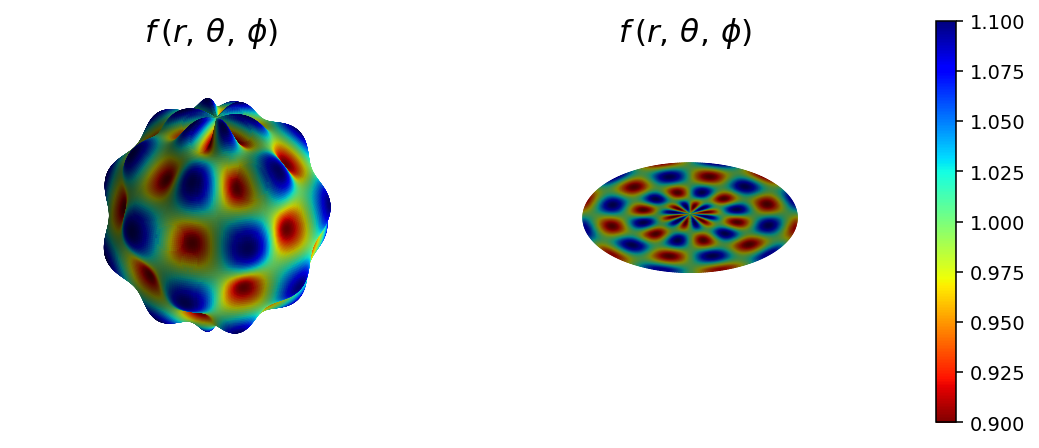


Expanding function onto spherical harmonics...
 

Coefficients:

(a^0_0)_0 = +3.460236E+00
(b^6_7)_0 = +5.974413E-02
(b^6_9)_0 = -1.456218E-01
(a^0_0)_1 = +3.798405E+00
(b^6_7)_1 = +6.558293E-02
(b^6_9)_1 = -1.598534E-01
(a^0_0)_2 = -1.600514E+00
(b^6_7)_2 = -2.763432E-02
(b^6_9)_2 = +6.735656E-02
(a^0_0)_3 = -4.153276E+00
(b^6_7)_3 = -7.171010E-02
(b^6_9)_3 = +1.747879E-01
(a^0_0)_4 = -1.583446E+00
(b^6_7)_4 = -2.733964E-02
(b^6_9)_4 = +6.663828E-02
(a^0_0)_5 = +3.760300E+00
(b^6_7)_5 = +6.492500E-02
(b^6_9)_5 = -1.582497E-01
(a^0_0)_6 = +3.505387E+00
(b^6_7)_6 = +6.052369E-02
(b^6_9)_6 = -1.475219E-01


Recreating function from the coefficients...
 


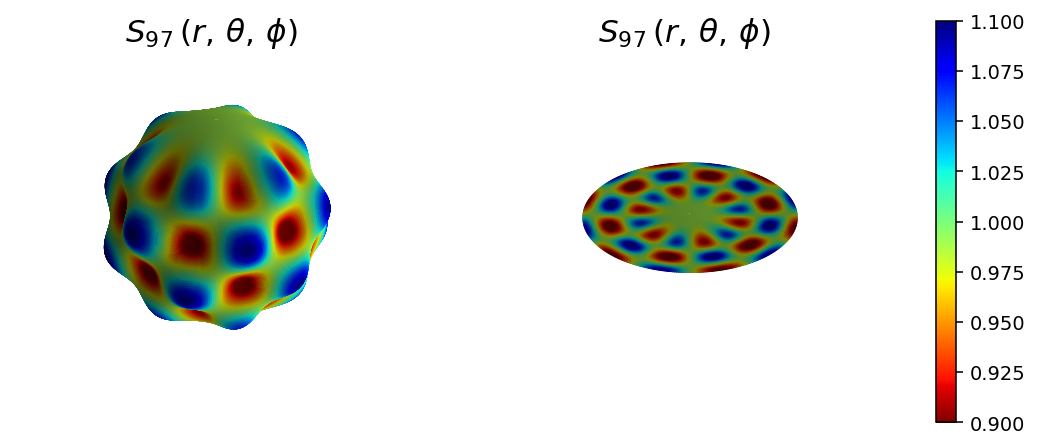

In [ ]:
if __name__ == "__main__":

  r     = np.linspace (r1, r2, Nr)
  theta = np.linspace (t1, t2, Nt)
  phi   = np.linspace (p1, p2, Np)

  rr, tt, pp = np.meshgrid (r, theta, phi, indexing = 'ij')

  F = f (rr, tt, pp)

  fig, axes = plt.subplots (1, 2,
                            subplot_kw = dict (projection = '3d'),
                            figsize = (10, 3.8), dpi = 140)

  ax1, ax2, = axes[0], axes[1]

  PHI, THETA = np.meshgrid (phi, theta)

  F1 = F[Nr - 1, :, :]

  X = F1 * np.sin (THETA) * np.cos (PHI)
  Y = F1 * np.sin (THETA) * np.sin (PHI)
  Z = F1 * np.cos (THETA)

  vmin = min (F1.ravel ())
  vmax = max (F1.ravel ())

  norm = colors.Normalize (vmin = vmin, vmax = vmax)
  cbar = cm.ScalarMappable (norm = norm, cmap = cm.jet_r)
  cbar.set_array ([])

  cmap = cm.jet_r (norm (F1))

  ax1.plot_surface (X, Y, Z, rstride = 1, cstride = 1,
                    facecolors = cmap)

  ax1.set_title (r'$f\,(r,\,\theta,\,\phi)$', fontsize = 16)

  ax1.set_box_aspect ((np.ptp (X),
                       np.ptp (Y),
                       np.ptp (Z)))

  ax1.set_xlim (-1, 1)
  ax1.set_ylim (-1, 1)
  ax1.set_zlim (-1, 1)
  ax1.axis ('off')

  PHI, R = np.meshgrid (phi, r)

  F2 = F[:, Nt // 2, :]

  X = R * np.cos (PHI)
  Y = R * np.sin (PHI)
  Z = 0.01 * F2

  ax2.plot_surface (X, Y, Z, rstride = 1, cstride = 1,
                    facecolors = cmap)

  ax2.set_title (r'$f\,(r,\,\theta,\,\phi)$', fontsize = 16)

  fig.colorbar (cbar, ax = axes.ravel ().tolist ())

  ax2.set_box_aspect ((np.ptp (X),
                       np.ptp (Y),
                       np.ptp (Z)))

  ax2.set_xlim (-1, 1)
  ax2.set_ylim (-1, 1)
  ax2.set_zlim (-1, 1)
  ax2.axis ('off')

  plt.show ()

  Tn = np.array ([r1, 0.35, 0.50, 0.65, r2])

  print ('\nExpanding function onto spherical harmonics...\n ')

  a, b = coefficients (Nr, Nt, Np, F, nn, ng, Tn, nmax)

  print ('\nCoefficients:\n')

  for s in range (nn + ng - 1):

    for n in range (nmax + 1):

      for m in range (n + 1):

        if abs (a[s, index (m, n)]) > 1e-5:

          print ('(a^{}_{})_{} = {:+E}'.format (m, n, s,
                                                a[s, index (m, n)]))

        if abs (b[s, index (m, n)]) > 1e-5:

          print ('(b^{}_{})_{} = {:+E}'.format (m, n, s,
                                                b[s, index (m, n)]))

  print ('\n\nRecreating function from the coefficients...\n ')

  S = sRCS (Nr, Nt, Np, nn, ng, Tn, nmax, a, b)

  fig, axes = plt.subplots (1, 2,
                            subplot_kw = dict (projection = '3d'),
                            figsize = (10, 3.8), dpi = 140)

  ax1, ax2, = axes[0], axes[1]

  PHI, THETA = np.meshgrid (phi, theta)

  S1 = S[Nr - 1, :, :]

  X = S1 * np.sin (THETA) * np.cos (PHI)
  Y = S1 * np.sin (THETA) * np.sin (PHI)
  Z = S1 * np.cos (THETA)

  cmap = cm.jet_r (norm (S1))

  ax1.plot_surface (X, Y, Z, rstride = 1, cstride = 1,
                    facecolors = cmap)

  ax1.set_title (r'${{S_{{{}}}}}_{{{}}}\,'\
                 r'(r,\,\theta,\,\phi)$'.format (nmax, nn + ng - 1),
                 fontsize = 16)

  ax1.set_box_aspect ((np.ptp (X),
                       np.ptp (Y),
                       np.ptp (Z)))

  ax1.set_xlim (-1, 1)
  ax1.set_ylim (-1, 1)
  ax1.set_zlim (-1, 1)
  ax1.axis ('off')

  PHI, R = np.meshgrid (phi, r)

  S2 = S[:, Nt // 2, :]

  X = R * np.cos (PHI)
  Y = R * np.sin (PHI)
  Z = 0.01 * S2

  ax2.plot_surface (X, Y, Z, rstride = 1, cstride = 1,
                    facecolors = cmap)

  ax2.set_title (r'${{S_{{{}}}}}_{{{}}}\,'\
                 r'(r,\,\theta,\,\phi)$'.format (nmax, nn + ng - 1),
                 fontsize = 16)

  fig.colorbar (cbar, ax = axes.ravel ().tolist ())

  ax2.set_box_aspect ((np.ptp (X),
                       np.ptp (Y),
                       np.ptp (Z)))

  ax2.set_xlim (-1, 1)
  ax2.set_ylim (-1, 1)
  ax2.set_zlim (-1, 1)
  ax2.axis ('off')

  plt.show ()

####References



“Associated Legendre Polynomials.” *Wikipedia*, Wikimedia Foundation, 27 Apr. 2020, https://en.wikipedia.org/wiki/Associated_Legendre_polynomials [Accessed 15 July 2020]. 
<br>
<br>
Dahlen, F., & Tromp, J., 1998. *Theoretical global seismology.* Princeton university press, pp. 847-850.
<br>
<br>
de Boor, C., 2001. *A Practical Guide to Splines.* Revised Edition (with 32 figures). Springer-Verlag, pp. 87-90 ISBN 0-387-95366-3. 
<br>
<br>
Freeman, A. (1878). *The Analytical Theory of Heat.* Cambridge University Press, Cambridge UK
<br>
<br>
Hobson, E. W., 1931. *The Theory of Spherical and Ellipsoidal Harmonics.* Cambrige University Press, p. 107.
<br>
<br>
Johansson, Robert. “Google Colaboratory.” *Google*, Google, https://colab.research.google.com/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-6A-Fortran-and-C.ipynb [Accessed 25 July 2020].
<br>
<br>
Lei, W., Ruan, Y., Bozdağ, E., Peter, D., Lefebvre, M., Komatitsch, D.,Tromp, J., Hill, J., Podhorszki, N., & Pugmire, D., 2020. *Global Adjoint Tomography - Model GLAD-M25*. Geophys. J. Int., ggaa253, https://doi.org/10.1093/gji/ggaa253
<br>
<br>
“Markevery Demo.” Markevery Demo - Matplotlib 3.1.2 Documentation, https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/markevery_demo.html [Accessed 16 July 2020].
<br>
<br>
“Trigonometric series.” *Encyclopedia of Mathematics*. http://encyclopediaofmath.org/index.php?title=Trigonometric_series&oldid=49638 [Accessed 18 July 2020].
<br>
<br>
Weisstein, Eric W. “Fourier-Legendre Series.” *From MathWorld* - A Wolfram Web Resource. https://mathworld.wolfram.com/Fourier-LegendreSeries.html [Accessed 16 July 2020].
<br>
<br>
Wiggins, R. A., & Saito, M., 1971. *Evaluation of computational algorithms for the associated Legendre polynomials by interval analysis.* Bulletin of the Seismological Society of America, v. 61 n° 2, p. 109.
<br>
<br>